In [151]:
import subprocess
output = subprocess.check_output('sbatch solar.sbatch', shell=True)
print(output)

b'Submitted batch job 1962085\n'


In [141]:
import subprocess
output = subprocess.check_output('sbatch solar2.sbatch', shell=True)
print(output)

b'Submitted batch job 1960995\n'


In [63]:
import re
line = re.search("\d+", output.decode("utf-8"))
line.group()

'1959758'

In [138]:
subprocess.check_output('scancel 1960990 1960991 1960992', shell=True)

b''

In [147]:
subprocess.check_output("squeue", shell = True).decode("utf-8")

'             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)\n           1960997       cpu     bash  maximer  R      38:09      1 enc3-node6\n           1960959       gpu    solar  maneesh  R    4:06:32      1 gpu-380-10\n           1960987       gpu    solar  maneesh  R    1:45:43      1 gpu-380-16\n           1960995       gpu    solar  maneesh  R    1:22:49      1 gpu-380-13\n           1961001       gpu    solar  maneesh  R      28:17      1 gpu-380-12\n           1961000       gpu    solar  maneesh  R      28:18      1 gpu-380-14\n           1720536       cpu semi_sup williamw  R 4-22:44:51      1 enc3-node6\n           1720537       cpu semi_sup williamw  R 4-22:26:23      1 enc3-node6\n           1954602       cpu   seqRNN  duncker  R 2-10:01:37      1 enc3-node6\n           1954601       cpu   seqRNN  duncker  R 2-10:02:30      1 enc3-node6\n           1957791       cpu   seqRNN  duncker  R   23:00:47      1 enc3-node6\n           1844597       cpu   se

In [17]:
import numpy

file = open("./data_sun/sunspots/dailySunspotNumber.txt", "r")
fl = file.readlines()
npfl = numpy.zeros((len(fl)))
for i, x in enumerate(fl):
    npfl[i] = numpy.float32(x[21:24])

npfl.dtype    
    
numpy.var(npfl)    

2331.7306004635716

In [22]:
import torch
import torch.nn as nn 
from os import listdir as ld
import torchvision.transforms as transforms
import numpy as np
from PIL import Image as im
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(9, 12, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 10)
        self.conv3 = nn.Conv2d(16, 32, 10)
        self.fc1 = nn.Linear(100352, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 100352)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

net.load_state_dict(torch.load("./solar_net_1954600/solar_epoch_10.pth", map_location = torch.device("cpu")))

c = "./data_sun/images/2011/"
d = list(c + "01%2d" % (i+1) for i in range(4))
inp = []
for j in d:
    b = tuple(0.5 for i in range(len(ld(j))))
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(b, b)])
    images = np.zeros((len(ld(j)), 512, 512, 3))
    for i, x in enumerate(ld(j)):
        y = np.array(im.open(j + "/" + x))
        if y.shape == (512, 512):
            images[i] = np.broadcast_to(y.reshape(512, 512, 1), (512, 512, 3))
        else:
            images[i] = np.array(im.open(c + "/" + x))
    images = np.average(images, axis = 3)
    images = np.array(images, dtype = "uint8")
    images = np.transpose(images, (1, 2, 0))
    images = transform(images)
    inp.append(images)
    
input = np.array(inp)

net(input)

FileNotFoundError: [Errno 2] No such file or directory: './data_sun/images/2011/01 1'

In [37]:
import os
os.environ["OMP_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
# job_id = os.environ["SLURM_JOB_ID"]

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image as im
import math
from os import listdir as ld
import random

def im_square_crop(img_file):
    img = im.open(img_file)
    oldsize = img.size
    newsize = tuple(min(oldsize) for i in range(2))
    coords = list(math.floor((oldsize[i]-newsize[i])/2) for i in range(2))
    for i in range(2):
        coords.append(coords[i]+newsize[0])
    for i in range(len(coords)):
        coords[i] = round(coords[i])
    img = img.crop(tuple(coords))
    return img

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(9, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(147456, 120)
        self.drop = nn.Dropout(p = 0.2)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
 
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 147456)
        x = self.drop(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# def imshow(img, ax):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     if npimg.shape == (512, 512):
#         npimg = np.repeat(npimg[:, :, np.newaxis], 3, axis = 2)
#     ax.imshow(npimg)


class SunDataset(torch.utils.data.Dataset):
    def __init__(self, input_dir, data_file, train = False, test = False):
        super(SunDataset).__init__()

        def makeList(input, slice, split):
            output = list(i for i in input)
            for i, x in enumerate(output):
                output[i] = x[slice[0]:slice[1]].split(split)
                bl = []
                for j, y in enumerate(output[i]):
                    try:
                        output[i][j] = float(y)
                    except ValueError:
                        bl.append(y)
                for k in bl:
                    output[i].remove(k)
                    bl.remove(k)                  
            return output
        
        def cutset(dataset, sampling, inv = False):
            newset = []
            if not inv:
                for i in range(0, len(dataset), sampling):
                    newset.append(dataset[i])
            elif inv:
                x = list(range(len(dataset)))
                for i in range(0, len(dataset), sampling):
                    x.remove(i)
                for i in x:
                    newset.append(dataset[i])
            return newset

        self.input_dir = input_dir
        self.images = []
        for i in ld(self.input_dir):
            for j in ld("{}/{}".format(self.input_dir, i)):
                x = tuple("{}/{}/{}/{}".format(self.input_dir, i, j, k) for k in ld("{}/{}/{}".format(self.input_dir, i, j)))
                if len(x) == 9:
                    self.images.append(x)
        f = open(data_file, "r")
        m = open("./data_sun/missing_days.txt", "r")
        ml = m.readlines()
        ml = makeList(ml, [6, 16], "/")
        new_ml = []
        for i in ml:
            if i not in new_ml:  
                new_ml.append(i) 

        ml = new_ml 
        # for i in ml:
        #     if ml.count(i) != 1:
        #         print(i)
        #         print(ml.count(i))

        # check = makeList()

        self.data = f.readlines()
        checker = makeList(self.data, [0, 10], " ")
                
        for x in ml:
            try:
                ind = checker.index(x)
                del checker[ind]
                del self.data[ind]
            except ValueError:
                pass
            
        # for i in checker:
        #     for j, x in enumerate(i):
        #         if len(str(int(x))) == 1:
        #             i[j] = "0" + str(int(x))
        #         else:
        #             i[j] = str(int(x))
        #     path = "./data_sun/images/{}/{}".format(i[0], i[1] + i[2])
        #     if not os.path.isdir(path):
        #         print(path)

        for i, data in enumerate(self.data):
            self.data[i] = float(data[21:24])

        if train:
            self.images = cutset(self.images, 5, inv = True)
            self.data = cutset(self.data, 5, inv = True)
        elif test:
            self.images = cutset(self.images, 5)
            self.data = cutset(self.data, 5)


    def __getitem__(self, idx):
        a = tuple(0.5 for i in range(len(self.images[idx])))
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(a, a)])
        images = np.zeros((len(self.images[idx]), 412, 412, 3))
        for i, x in enumerate(self.images[idx]):
            y = np.array(im.open(x))
            if y.shape == (412, 412):
                images[i] = np.broadcast_to(y.reshape(412, 412, 1), (412, 412, 3))
            else:
                images[i] = np.array(im.open(x))
        images = np.average(images, axis = 3)
        images = np.array(images, dtype = "uint8")
        images = np.transpose(images, (1, 2, 0))
        images = transform(images)
        val = torch.Tensor([np.double(self.data[idx + 7])])
        return (images, val)

    def __len__(self):
        return len(self.data) - 7

trainsets = SunDataset("./data_sun/images_crop", "./data_sun/sunspots/dailySunspotNumber.txt", train = True)
testsets = SunDataset("./data_sun/images_crop", "./data_sun/sunspots/dailySunspotNumber.txt", test = True)
dataset = SunDataset("./data_sun/images_crop", "./data_sun/sunspots/dailySunspotNumber.txt")

trainloaders = torch.utils.data.DataLoader(trainsets, batch_size=4, shuffle=True, num_workers=0)

testloaders = torch.utils.data.DataLoader(testsets, batch_size=4, shuffle=False, num_workers=0)

# k = random.randint(0, len(dataset.images))

# figs, axs = plt.subplots(3, 3)
# for i in range(9):
#     imshow(dataset[k][0][i], axs[int(i/3)][i%3])
#     axs[int(i/3)][i%3].set_yticks([])
#     axs[int(i/3)][i%3].set_xticks([])
#     axs[int(i/3)][i%3].set_title("{} $\AA$".format(dataset.images[k][i][-8:-4]))
# plt.suptitle("Images of the Sun on {}".format(k))
# print(dataset[k][1])
# plt.show()


# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cpu")
# print(torch.cuda.is_available())

net = Net()

loader = torch.load("./solar_net_1962085/solar_epoch_30_offset_2days.pth", map_location = device)
state_dict = net.state_dict()
for i in loader.keys():
    state_dict[i] = loader[i]
net.load_state_dict(state_dict)

net.eval()

targets = []
outputs = []
with torch.no_grad():
    for i in testloaders:
        targets += i[1]
        outputs += net(i[0])

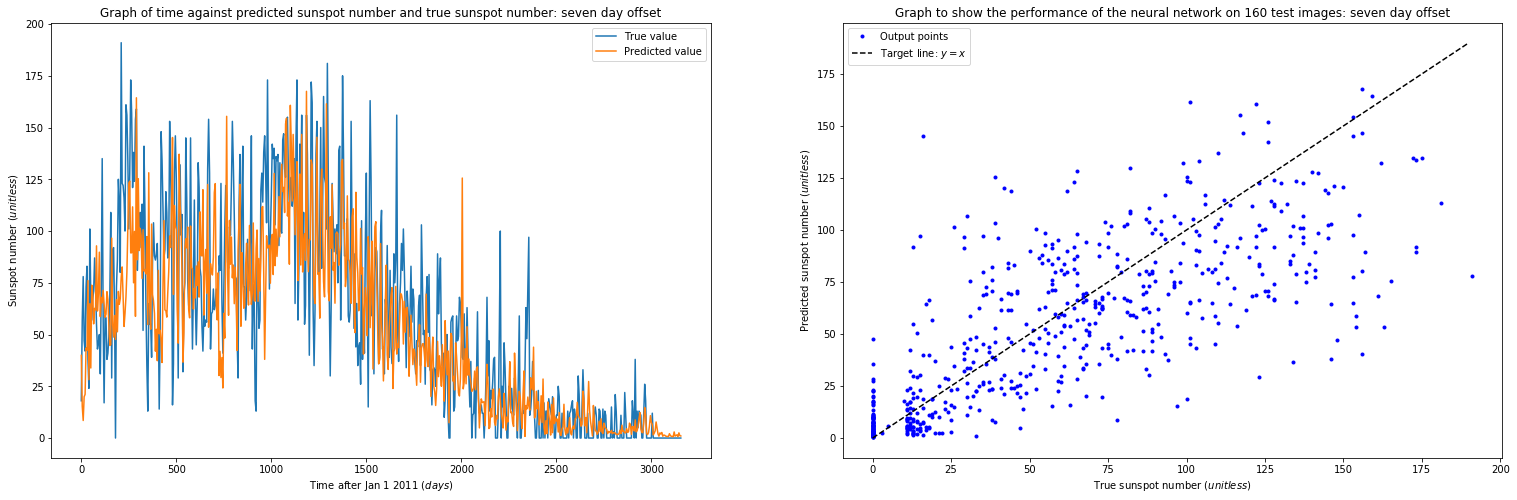

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (26, 8))
line1, line2 = ax[0].plot(list(range(0, len(targets)*5, 5)), targets, list(range(0, len(outputs)*5, 5)), outputs)
line1.set_label("True value")
line2.set_label("Predicted value")
ax[0].legend()
data = list(i for i in range(int(max(np.array(targets)))))
line3, line4 = ax[1].plot(targets, outputs, ".b", data, data, "--k")
line3.set_label("Output points")
line4.set_label("Target line: ${y = x}$")
ax[1].legend()
ax[0].set_title("Graph of time against predicted sunspot number and true sunspot number: seven day offset")
ax[0].set_ylabel("Sunspot number ${(unitless)}$")
ax[0].set_xlabel("Time after Jan 1 2011 ${(days)}$")
ax[1].set_title("Graph to show the performance of the neural network on 160 test images: seven day offset")
ax[1].set_ylabel("Predicted sunspot number ${(unitless)}$")
ax[1].set_xlabel("True sunspot number ${(unitless)}$")
plt.savefig("figure_results_7_days_ahead.png")
plt.show()